In [1]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from mlxtend.preprocessing import TransactionEncoder
import random
from mlxtend.frequent_patterns import apriori
import pyfpgrowth
from format_rules import format_rules
#from server_association import server_association
from Server_Assign import server_association
from assign_servers import assign_servers_output

In [2]:
#load data
#df=pd.read_csv('/home/natalie/Documents/Manifold/df_test.csv')
client = boto3.client('s3')
obj = client.get_object(Bucket='manifolddata', Key='week1.csv')
df = pd.read_csv(BytesIO(obj['Body'].read()), low_memory=False)


df=df.iloc[:,[0,1,3,4,5,6,7,8]]
df.columns=['Date', 'Duration', 'Src_IP', 'Src_pt', 'Dst_IP', 'Dst_pt','Packets', 'Bytes']
#add an date column that is rounded to nearest hour, so we can use this as a timestep to see how frequently IP pairs occur in each timestep
df['Date']=pd.to_datetime(df['Date'], format="%Y-%m-%d %H:%M:%S.%f", errors = 'coerce')
df['date_hr']=pd.Series(df['Date']).dt.round("H")


In [3]:
#create a pair column, which is a touple of the src and dst IP, sorted. 
#It does not matter which call came first, we simply want to know which pair occurs most frequently.

df['pairs']=list(zip(df.Src_IP, df.Dst_IP))
df['pairs']=df['pairs'].apply(sorted)
df['pairs2']=tuple(df['pairs'])
#create a normalized latency column = duration/packets
df['norm_latency']=df['Duration']/df['Packets']

In [4]:
def convert_si_to_number(x):
    total_stars = 0
    if 'k' in x:
        if len(x) > 1:
            total_stars = float(x.replace('k', '')) * 1000 # convert k to a thousand
    elif 'M' in x:
        if len(x) > 1:
            total_stars = float(x.replace('M', '')) * 1000000 # convert M to a million
    elif 'B' in x:
        total_stars = float(x.replace('B', '')) * 1000000000 # convert B to a Billion
    else:
        total_stars = int(x) # Less than 1000
    return int(total_stars)

In [5]:
df.Bytes=df.Bytes.astype('str')
test_list=df.Bytes

[i for i, s in enumerate(test_list) if 'M' in s]#show where the M errors are happening

test_list= [convert_si_to_number(x) for x in test_list]
df.Bytes=test_list #bring it back into the dataframe


In [6]:
df.head()

,Date,Duration,Src_IP,Src_pt,Dst_IP,Dst_pt,Packets,Bytes,date_hr,pairs,pairs2,norm_latency
0,2017-08-02 00:00:00.419,0.003,192.168.210.55,44870,192.168.100.11,445.0,2,174,2017-08-02,"[192.168.100.11, 192.168.210.55]","(192.168.100.11, 192.168.210.55)",0.0015
1,2017-08-02 00:00:00.421,0.000,192.168.100.11,445,192.168.210.55,44870.0,1,108,2017-08-02,"[192.168.100.11, 192.168.210.55]","(192.168.100.11, 192.168.210.55)",0.0000
2,2017-08-02 00:00:02.593,0.004,192.168.220.47,55101,192.168.100.11,445.0,2,174,2017-08-02,"[192.168.100.11, 192.168.220.47]","(192.168.100.11, 192.168.220.47)",0.0020
3,2017-08-02 00:00:02.859,0.000,10000_34,443,192.168.210.54,59628.0,1,100,2017-08-02,"[10000_34, 192.168.210.54]","(10000_34, 192.168.210.54)",0.0000
4,2017-08-02 00:00:02.594,0.000,192.168.100.11,445,192.168.220.47,55101.0,1,108,2017-08-02,"[192.168.100.11, 192.168.220.47]","(192.168.100.11, 192.168.220.47)",0.0000


## Implement Frequent Pattern (FP) - Growth algorithm

https://fp-growth.readthedocs.io/en/latest/usage.html

This algorithm
1. Counts occurence of items in dataset in 1st pass
2. Build FP-tree by inserting instances, and adds count to each instance based on the number of times it appears in the dataset. Those infrequent instances are dropped from the tree.

This allows the frequentest set to be generated organically, instead of creating a list of each itemset and checking if it does/does not pass minimum threshold (like Apriori algorithm)

#### Vocabulary
 - itemset = all items in 1 transaction
A "pattern" is a conjunction of items, or the unique itemset.
A "rule" X --> Y means if you buy X you are likely to buy Y, or in this case if X IP address is used Y IP address is likely also


#### Evaluation metrics include:

1. Support = how frequently it occurs. The number of transactions of that unique itemset / all transactions. In this case: number of times IP pair occurs/all requests

2. Confidence = how often rule is likely to be true. frequency of X and Y occuring/ frequency of X occuring in entire dataset. Conditional probability of Y given X. P(Ey|Ex)

3. Lift = How likely is item Y given item X occurs, controlling for how frequent Y occurs in the entire dataset. For rule X-->Y, lift = P(Y|X)/P(Y).
    Lift = 1 means X and Y are independent
    Lift >1 = X and Y are positively correlated
    Lift <1 = X and Y are negatively correlated

This module does the following steps:
    
    1. Data manipulation, puts the dataframe in the correct form needed
    2. Frequent Pattern growth algorithm --> creates patterns and rules
    3. Merges in the latency and frequency information from the original data to prioritize the rules
    4. Assigns Apps to specific servers in order of prioritization
    5. Outputs:
        1. the dataframe with all the assigned servers adjacent to each transaction
        2. the app assignment table
        3. summation of latency times for the entire data
        4. summation of latency times for the enitre data if the model were applied
        5. and the data if it were assigned to the servers as prescribed by the model
        6. average transaction latency (s)
        7. average transaction latency modeled (s)
    
    
The input to the module are:
    1. df = dataframe cleaned as outlined above (I did not put this in code in case different dataframes are used). The format should be:
    Date, Duration, Src_IP,	Src_pt,	Dst_IP,	Dst_pt,	Packets, Bytes,	date_hr, pairs, pairs2, norm_latency
    Although order does not really matter, as any variables are called by name.
    2. Percentile = minimum number of occurances you want a particular pair of apps to pass. If this value = 0.4, then any pair that's frequency is >= the 40th percentile of all pairs occuriing in the entire dataset will be used to create rules.
    3. confidence = minimum threshold that you want the rule to be true within the entire dataset. If this value = 0.7 we want to be sure that the rule is true 70% of the time.
    4. apps_server = how many apps can fit on a server. If this value = 20 you can fit 20 apps on a server before it is full and we move on to the next one.

In [9]:
percentile=0.8
confidence=0.7
apps_server=20

server_df, server_assignments, total_latency, total_latency_model, avg_latency, avg_latency_model=assign_servers_output(df, percentile, confidence, apps_server)

In [10]:
total_latency

2014119.5810000007

In [11]:
total_latency_model

1884878.5070000016

How much of an improvement?

In [12]:
(total_latency-total_latency_model)/total_latency

0.06416752769755187

In [17]:
#sum up by an hourly timestep, get the average transaction time (s)

server_df_hour=server_df.groupby('hour')[['Duration', 'duration_pred']].mean().reset_index()

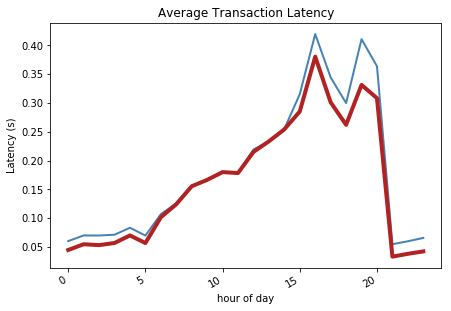

In [20]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

#plot average transaction time

fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.plot(server_df_hour['hour'], server_df_hour['Duration'], color='steelblue', linewidth=2.0)
ax.plot(server_df_hour['hour'], server_df_hour['duration_pred'], color='firebrick', linewidth=4.0)


## Rotate date labels automatically
fig.autofmt_xdate()
plt.ylabel('Latency (s)')
plt.xlabel('hour of day')
plt.title('Average Transaction Latency')
fig.savefig('Average_transaction_latency.png')

## How to optimize our min thresholds?

In [12]:
percentiles=np.linspace(0.1,1,4,endpoint=False)
confidences=np.linspace(0.1,1,4,endpoint=False)
apps_server=20

In [8]:
percentiles

array([0.1  , 0.325, 0.55 , 0.775])

In [13]:
data_l=list(df['pairs'])
pairs_count=(df.groupby('pairs2').agg({'Date':'count', 'norm_latency': 'mean', 'Duration': 'sum', 'Packets':'sum'}).reset_index())
pairs_count.columns=['pairs','frequency', 'avg_norm_latency', 'total_duration', 'total_packets']
pairs_count['norm_latency']=(pairs_count['total_duration']/pairs_count['total_packets'].sum())*100 #sum of all duration time divided by sum of all packets transfered for that pair


In [19]:
groups=[]
for i in percentiles:
    for j in confidences:
        groups.append(i)

In [14]:
len_apps_assigned=[]
total_latency_model_list=[]
avg_latency_list=[]
avg_latency_model_list=[]
percentile_list=[]
confidence_list=[]

groups=[]
for i in percentiles:
    for j in confidences:
        per_n=(pairs_count['frequency'].quantile(i))
        server_df, server_assignments, total_latency, total_latency_model, avg_latency, avg_latency_model=assign_servers_output(df, i, j, apps_server)
        len_apps_assigned.append(len(server_assignments))
        total_latency_model_list.append(total_latency_model)
        avg_latency_model_list.append(avg_latency_model)
        percentile_list.append(i)
        confidence_list.append(j)
        print(per_n)


6.0
6.0
6.0
6.0
18.0
18.0
18.0
18.0
38.0
38.0
38.0
38.0
108.0
108.0
108.0
108.0


In [17]:
model_matrix=pd.DataFrame({'percentile': percentile_list, 'confidence': confidence_list, 'len_apps_assigned':len_apps_assigned, 'total_latency_model':total_latency_model_list,  ' avg_latency_model': avg_latency_model_list})

In [24]:
model_matrix.to_csv('model_matrix_all.csv')
model_matrix

,percentile,confidence,len_apps_assigned,total_latency_model,avg_latency_model
0,0.100,0.100,3828,1885168.543,0.230292
1,0.100,0.325,3824,1890614.448,0.230957
2,0.100,0.550,3804,1890614.448,0.230957
3,0.100,0.775,3723,1890614.448,0.230957
4,0.325,0.100,2689,1884815.578,0.230249
5,0.325,0.325,2634,1890015.116,0.230884
6,0.325,0.550,2427,1890015.116,0.230884
7,0.325,0.775,2152,1890015.116,0.230884
8,0.550,0.100,1663,1882338.197,0.229946
9,0.550,0.325,1551,1886604.957,0.230467


### Train/Test split

In [23]:
train_df=df[df['Date']<'2017-08-08'] #first 6 days

In [24]:
test_df=df[df['Date']>'2017-08-08'] #last day

In [25]:
data_l_test=list(test_df['pairs'])

In [27]:
data_l_train=list(train_df['pairs'])

In [30]:
#group the dataset by unique pairs, then count how frequently each pair occurs, and also get the average normalized latency time for that pair. The latency times vary because the servers they are assigned are random.
pairs_count_train=(train_df.groupby('pairs2').agg({'Date':'count', 'norm_latency': 'mean', 'Duration': 'sum', 'Packets':'sum'}).reset_index())
pairs_count_train.columns=['pairs','frequency', 'avg_norm_latency', 'total_duration', 'total_packets']
pairs_count_train['norm_latency']=(pairs_count_train['total_duration']/pairs_count_train['total_packets'].sum())*100 #sum of all duration time divided by sum of all packets transfered for that pair

per_80_test=np.percentile(pairs_count_train['frequency'], [80])[0]
patterns_train = pyfpgrowth.find_frequent_patterns(data_l_train, per_80_test) 


In [35]:
patterns_train_df=pd.DataFrame.from_dict(patterns_train ,orient='index')
patterns_train_df.to_csv('patterns_train_80.csv' )

In [38]:
confidence=0.7 #this means the rule is likely to be true 20% of the time, it is a high threshold, used for testing
rules_train = pyfpgrowth.generate_association_rules(patterns_train, confidence)

In [40]:
rules_df_80per_70con_test=format_rules(rules_train, train_df, 20) 

In [41]:
server_df80_test, server_assignments80_test, total_latency_test, total_latency80_test, avg_latency_test, avg_latency80_test = server_association(rules_df_80per_70con_test, test_df, 20) #this function loaded from server_assocation.py file
#assign rules created by the training data to the test data

How did our test data do against our model?

In [64]:
total_latency_test

506250.077

In [65]:
total_latency80_test

501156.24000000005

In [43]:
#add hour column,here it is a value 1-24, and repeats each day
server_df80_test['hour']=None
server_df80_test['hour']=pd.DatetimeIndex(server_df80_test['Date']).hour

In [60]:
server_df80_test_hour=server_df80_test.groupby('hour').agg({'Date':'count', 'norm_latency': 'mean', 'Duration': ['sum','mean'], 'Packets':'sum', 'duration_pred': ['sum', 'mean'],}).reset_index()

In [62]:
server_df80_test_hour.columns=['hour', 'transactions', 'norm_latency_mean', 'duration_total', 'duration_mean', 'packets_total', 'duration_pred_total', 'duration_pred_mean']
server_df80_test_hour.head()

,hour,transactions,norm_latency_mean,duration_total,duration_mean,packets_total,duration_pred_total,duration_pred_mean
0,0,22084,0.012514,1181.750,0.053512,43855,819.881,0.037126
1,1,16555,0.014949,1068.873,0.064565,36752,710.035,0.042889
2,2,18027,0.016853,1346.696,0.074704,40233,932.685,0.051738
3,3,17184,0.016476,1171.800,0.068191,35798,818.149,0.047611
4,4,21267,0.018811,1857.150,0.087325,51920,1453.192,0.068331


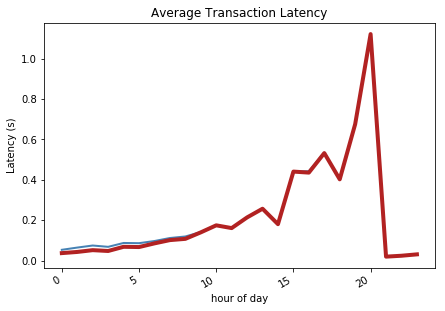

In [63]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.plot(server_df80_test_hour['hour'], server_df80_test_hour['duration_mean'], color='steelblue', linewidth=2.0)
ax.plot(server_df80_test_hour['hour'], server_df80_test_hour['duration_pred_mean'], color='firebrick', linewidth=4.0)


## Rotate date labels automatically
fig.autofmt_xdate()
plt.ylabel('Latency (s)')
plt.xlabel('hour of day')
plt.title('Average Transaction Latency')
fig.savefig('Average_transaction_latency_test.png')